# Convolution and Kernels

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import Tensor
import math
from typing import Tuple, List

In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [3]:
input_data = np.array([
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 0, 0],
    [0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0]
])

kernel = np.array([
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
])

output = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        # extract the patch from input
        patch = input_data[i:i+3, j:j+3]
        # element-wise multiplication and sum
        output[i, j] = np.sum(patch * kernel)

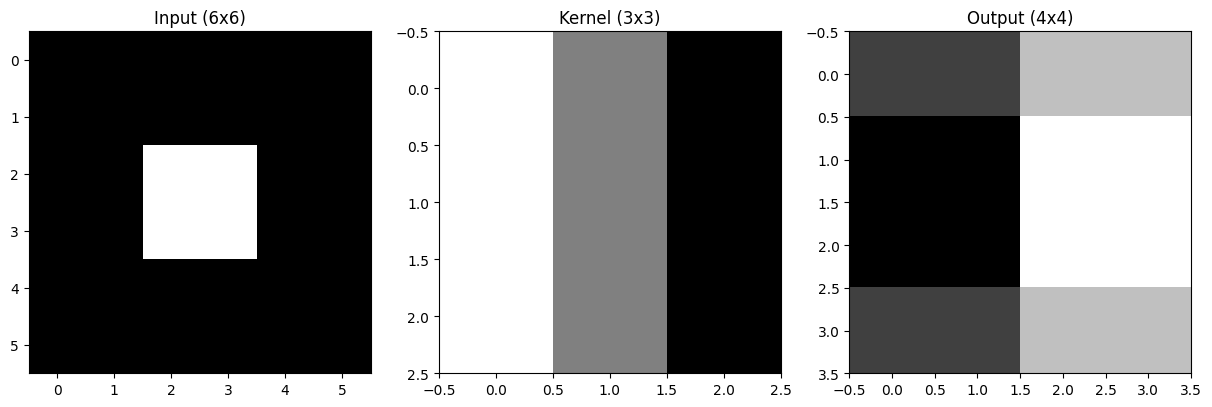

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(input_data, cmap='gray')
axs[0].set_title('Input (6x6)')
axs[1].imshow(kernel, cmap='gray')
axs[1].set_title('Kernel (3x3)')
axs[2].imshow(output, cmap='gray')
axs[2].set_title('Output (4x4)')

for ax in axs:
    ax.grid(False)

plt.show()

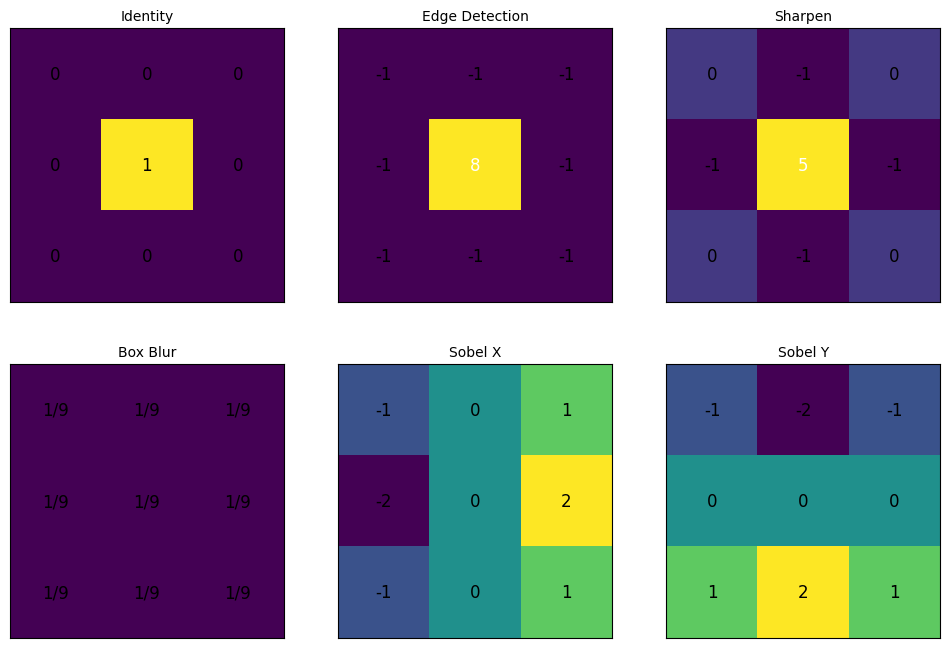

In [5]:
kernels = {
    'Identity': np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]),
    'Edge Detection': np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]),
    'Sharpen': np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]),
    'Box Blur': np.array([[1/9, 1/9, 1/9], [1/9, 1/9, 1/9], [1/9, 1/9, 1/9]]),
    'Sobel X': np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]),
    'Sobel Y': np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
}

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()

for i, (name, kernel) in enumerate(kernels.items()):
    im = axs[i].imshow(kernel, cmap='viridis')
    axs[i].set_title(name, fontsize=10)
    
    for row in range(3):
        for col in range(3):
            value = kernel[row, col]
            if abs(value) < 0.2 and value != 0:
                text = f"1/9"
            else:
                text = f"{value:.0f}" if value.is_integer() else f"{value:.1f}"
            axs[i].text(col, row, text, ha="center", va="center", 
                        color="white" if abs(value) > 3 else "black", fontsize=12)
    
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [6]:
input_data = np.array([
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 0, 0],
    [0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1]
])

outputs = []

for i, (name, kernel) in enumerate(kernels.items()):
    output = np.zeros((4, 4))
    for i in range(4):
        for j in range(4):
            patch = input_data[i:i+3, j:j+3]
            output[i, j] = np.sum(patch * kernel)
            
    outputs.append(output)

In [7]:
outputs

[array([[0., 0., 0., 0.],
        [0., 1., 1., 0.],
        [0., 1., 1., 0.],
        [0., 0., 0., 0.]]),
 array([[-1., -2., -2., -1.],
        [-2.,  5.,  5., -3.],
        [-2.,  5.,  5., -4.],
        [-1., -2., -2., -4.]]),
 array([[ 0., -1., -1.,  0.],
        [-1.,  3.,  3., -1.],
        [-1.,  3.,  3., -2.],
        [ 0., -1., -1., -1.]]),
 array([[0.11111111, 0.22222222, 0.22222222, 0.11111111],
        [0.22222222, 0.44444444, 0.44444444, 0.33333333],
        [0.22222222, 0.44444444, 0.44444444, 0.44444444],
        [0.11111111, 0.22222222, 0.22222222, 0.44444444]]),
 array([[ 1.,  1., -1., -1.],
        [ 3.,  3., -3., -2.],
        [ 3.,  3., -3.,  0.],
        [ 1.,  1., -1.,  3.]]),
 array([[ 1.,  3.,  3.,  1.],
        [ 1.,  3.,  3.,  2.],
        [-1., -3., -3.,  0.],
        [-1., -3., -3., -1.]])]

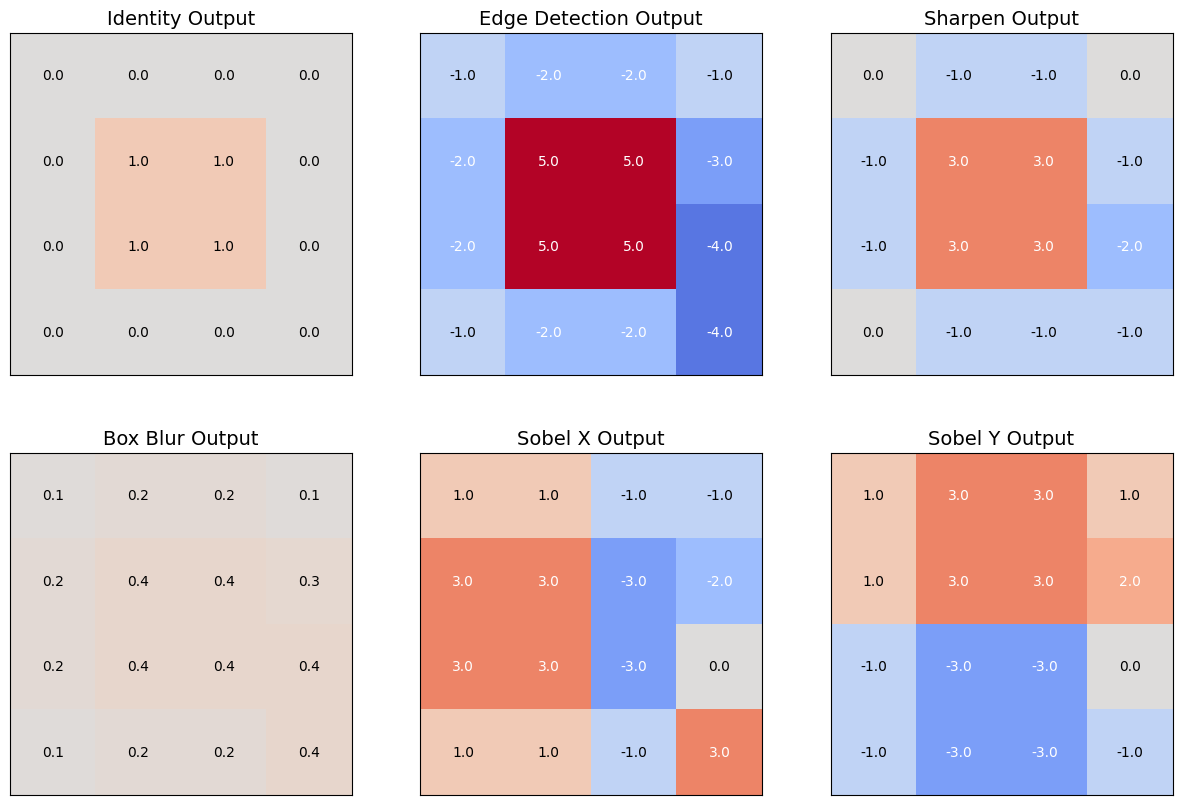

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

all_outputs = np.array(outputs)
vmax = np.max(np.abs(all_outputs))
vmin = -vmax

for i, (name, output) in enumerate(zip(kernels.keys(), outputs)):
    im = axs[i].imshow(output, cmap='coolwarm', vmin=vmin, vmax=vmax)
    axs[i].set_title(f'{name} Output', fontsize=14)
    
    for row in range(output.shape[0]):
        for col in range(output.shape[1]):
            value = output[row, col]
            text_color = "black" if -2 < value < 2 else "white"
            axs[i].text(col, row, f"{value:.1f}", ha="center", va="center", 
                     color=text_color, fontsize=10)
    
    axs[i].set_xticks([])
    axs[i].set_yticks([])

# Padding and Stride

In [9]:
input_data = np.array([
    [0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1],
    [0, 0, 1, 1, 0, 1],
    [0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1]
])

padding = 1

height, width = input_data.shape
padded = np.zeros((height + 2*padding, width + 2*padding))
padded[padding:padding+height, padding:padding+width] = input_data

print(f"original input:\n{input_data}\n")
print(f"padded input:\n{padded}")

original input:
[[0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 1 1 0 1]
 [0 0 1 1 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]]

padded input:
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1. 0. 1. 0.]
 [0. 0. 0. 1. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


In [10]:
stride = 2

output_height = ((input_data.shape[0] - kernel.shape[0]) // stride) + 1
output_width = ((input_data.shape[1] - kernel.shape[1]) // stride) + 1
output_strided = np.zeros((output_height, output_width))

row = 0
for i in range(0, input_data.shape[0] - kernel.shape[0] + 1, stride):
    col = 0
    for j in range(0, input_data.shape[1] - kernel.shape[1] + 1, stride):
        patch = input_data[i:i+3, j:j+3]
        output_strided[row, col] = np.sum(patch * kernel)
        col += 1
    row += 1

print("strided output shape:", output_strided.shape)

strided output shape: (2, 2)


# RGB

In [12]:
input_R = np.zeros((6, 6))
input_R[1:5, 1:5] = 1  # red square

input_G = np.zeros((6, 6))
input_G[2:4, 2:4] = 1  # green small square

input_B = np.zeros((6, 6))
input_B[0:3, 3:6] = 1  # blue rectangle

input_3c = np.stack([input_R, input_G, input_B], axis=0)  # Shape: (3, 6, 6)

In [13]:
filter1 = np.array([
    [[1, 0, -1], [1, 0, -1], [1, 0, -1]],  # For R channel
    [[0, 0, 0], [0, 1, 0], [0, 0, 0]],     # For G channel
    [[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]  # For B channel
])
    
filter2 = np.array([
    [[0, 1, 0], [1, -4, 1], [0, 1, 0]],    # For R channel
    [[1, 1, 1], [1, 1, 1], [1, 1, 1]],     # For G channel
    [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]   # For B channel
])

output_1 = np.zeros((4, 4))
output_2 = np.zeros((4, 4))

for i in range(4):
    for j in range(4):
        sum1 = 0
        sum2 = 0
        for c in range(3):  # 3 input channels
            patch = input_3c[c, i:i+3, j:j+3]
            sum1 += np.sum(patch * filter1[c])
            sum2 += np.sum(patch * filter2[c])
        
        output_1[i, j] = sum1
        output_2[i, j] = sum2

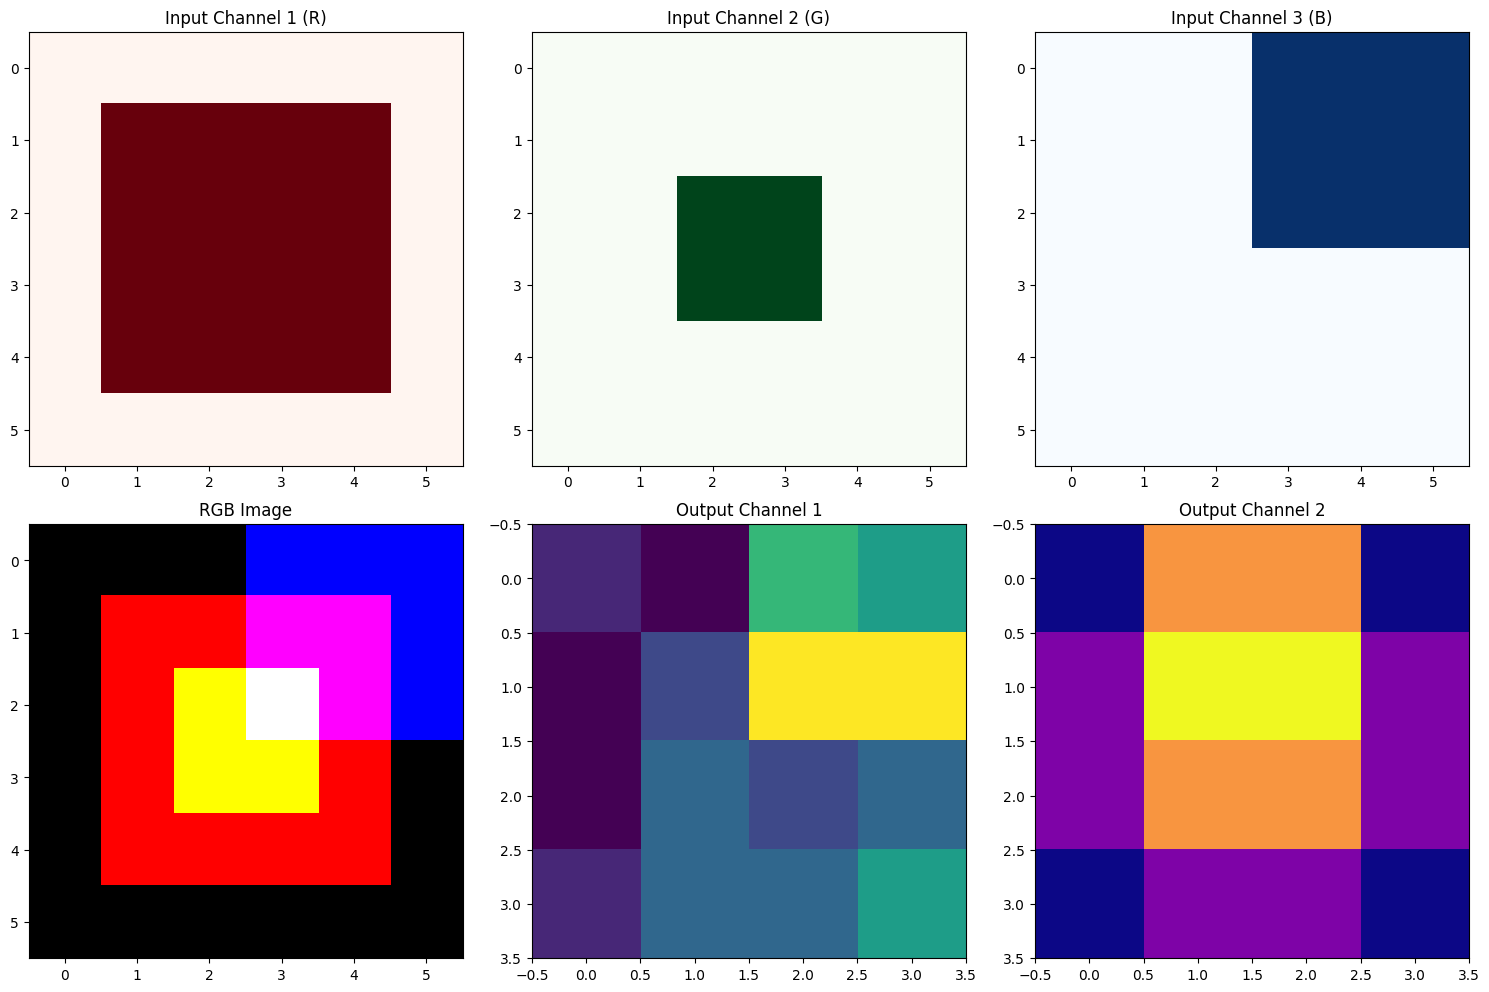

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    
# Show input channels
axs[0, 0].imshow(input_R, cmap='Reds')
axs[0, 0].set_title('Input Channel 1 (R)')

axs[0, 1].imshow(input_G, cmap='Greens')
axs[0, 1].set_title('Input Channel 2 (G)')

axs[0, 2].imshow(input_B, cmap='Blues')
axs[0, 2].set_title('Input Channel 3 (B)')

# Combine RGB for visualization
rgb_img = np.stack([input_R, input_G, input_B], axis=-1)
axs[1, 0].imshow(rgb_img)
axs[1, 0].set_title('RGB Image')

# Show output channels
axs[1, 1].imshow(output_1, cmap='viridis')
axs[1, 1].set_title('Output Channel 1')

axs[1, 2].imshow(output_2, cmap='plasma')
axs[1, 2].set_title('Output Channel 2')

for ax in axs.flatten():
    ax.grid(False)

plt.tight_layout()
plt.show()